In [1]:
import numpy as np
import pandas as pd
import gc
import random
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import NearestNeighbors
import lightgbm as lgb
import warnings
import math
from sklearn.tree import DecisionTreeClassifier

train_df = pd.read_pickle('data/train_data.pkl')
val_df = pd.read_pickle('data/val_data.pkl')
print(train_df.columns)
x_train = train_df.drop(train_df.columns[0:94], axis = 1)
x_val = val_df.drop(val_df.columns[0:94], axis = 1)
print(x_train.columns)
x_train = x_train.drop(['red_win', 'blue_win'], axis = 1)
x_train = x_train.reindex_axis(sorted(x_train.columns), axis=1)
x_val = x_val.drop(['red_win', 'blue_win'], axis = 1)
x_val = x_val.reindex_axis(sorted(x_val.columns), axis=1)
#x_train['actual_time'] = [float(x) for x in x_train['actual_time']]
y_train = train_df['winning_alliance']
y_val = val_df['winning_alliance']

Index(['actual_time', 'alliances.blue.dq_team_keys', 'alliances.blue.score',
       'alliances.blue.surrogate_team_keys', 'alliances.blue.team_keys',
       'alliances.red.dq_team_keys', 'alliances.red.score',
       'alliances.red.surrogate_team_keys', 'alliances.red.team_keys',
       'comp_level',
       ...
       'blueteam3_totalPoints', 'redteam1_totalPoints', 'redteam2_totalPoints',
       'redteam3_totalPoints', 'blueteam1_winningness',
       'blueteam2_winningness', 'blueteam3_winningness',
       'redteam1_winningness', 'redteam2_winningness', 'redteam3_winningness'],
      dtype='object', length=204)
Index(['blueteam1', 'blueteam2', 'blueteam3', 'redteam1', 'redteam2',
       'redteam3', 'red_win', 'blue_win', 'blueteam1_adjustPoints',
       'blueteam2_adjustPoints',
       ...
       'blueteam3_totalPoints', 'redteam1_totalPoints', 'redteam2_totalPoints',
       'redteam3_totalPoints', 'blueteam1_winningness',
       'blueteam2_winningness', 'blueteam3_winningness',
     

In [2]:
x_train.columns

Index(['blueteam1', 'blueteam1_adjustPoints', 'blueteam1_autoOwnershipPoints',
       'blueteam1_autoPoints', 'blueteam1_autoRunPoints',
       'blueteam1_autoScaleOwnershipSec', 'blueteam1_endgamePoints',
       'blueteam1_foulPoints', 'blueteam1_teleopOwnershipPoints',
       'blueteam1_teleopPoints',
       ...
       'redteam3_teleopOwnershipPoints', 'redteam3_teleopPoints',
       'redteam3_teleopScaleOwnershipSec', 'redteam3_teleopSwitchOwnershipSec',
       'redteam3_totalPoints', 'redteam3_vaultBoostTotal',
       'redteam3_vaultForceTotal', 'redteam3_vaultLevitateTotal',
       'redteam3_vaultPoints', 'redteam3_winningness'],
      dtype='object', length=108)

In [3]:
params = {
            'learning_rate': 0.03,
            'max_depth': -1,
            'feature_fraction': 0.3,
            'num_leaves' : 40,
            'objective': 'multiclass',
            'num_class': 3,
            'boosting_type':'gbdt',
            'metric': 'multi_error',
            'min_data' : 100,
            'verbose': -1,
            'min_data_in_bin' : 25
            }    
dtrain = lgb.Dataset(x_train, label = y_train)

# cross-validation

cv_result = lgb.cv(params, 
                   dtrain, 
                   nfold=4,
                   num_boost_round=5000,
                   early_stopping_rounds=200,
                   verbose_eval=20, 
                   show_stdv=False)
#num_boost_rounds = len(cv_result['l1-mean'])
#print(num_boost_rounds, cv_result['l1-mean'][-1])

[20]	cv_agg's multi_error: 0.196332
[40]	cv_agg's multi_error: 0.19005
[60]	cv_agg's multi_error: 0.186113
[80]	cv_agg's multi_error: 0.180083
[100]	cv_agg's multi_error: 0.177151
[120]	cv_agg's multi_error: 0.176731
[140]	cv_agg's multi_error: 0.175308
[160]	cv_agg's multi_error: 0.172293
[180]	cv_agg's multi_error: 0.171204
[200]	cv_agg's multi_error: 0.169027
[220]	cv_agg's multi_error: 0.169361
[240]	cv_agg's multi_error: 0.170199
[260]	cv_agg's multi_error: 0.169696
[280]	cv_agg's multi_error: 0.16911
[300]	cv_agg's multi_error: 0.169194
[320]	cv_agg's multi_error: 0.169696
[340]	cv_agg's multi_error: 0.168859
[360]	cv_agg's multi_error: 0.169026
[380]	cv_agg's multi_error: 0.16844
[400]	cv_agg's multi_error: 0.16844
[420]	cv_agg's multi_error: 0.168189
[440]	cv_agg's multi_error: 0.168859
[460]	cv_agg's multi_error: 0.168859
[480]	cv_agg's multi_error: 0.170282
[500]	cv_agg's multi_error: 0.170031
[520]	cv_agg's multi_error: 0.169696
[540]	cv_agg's multi_error: 0.170701
[560]	cv_

In [4]:
from sklearn.metrics import accuracy_score
clf  = lgb.train(params, dtrain, num_boost_round = 600, verbose_eval=50)
val_pred = np.argmax(clf.predict(x_val), axis = 1)
print(accuracy_score(y_val.values, val_pred))

0.7382726874177992


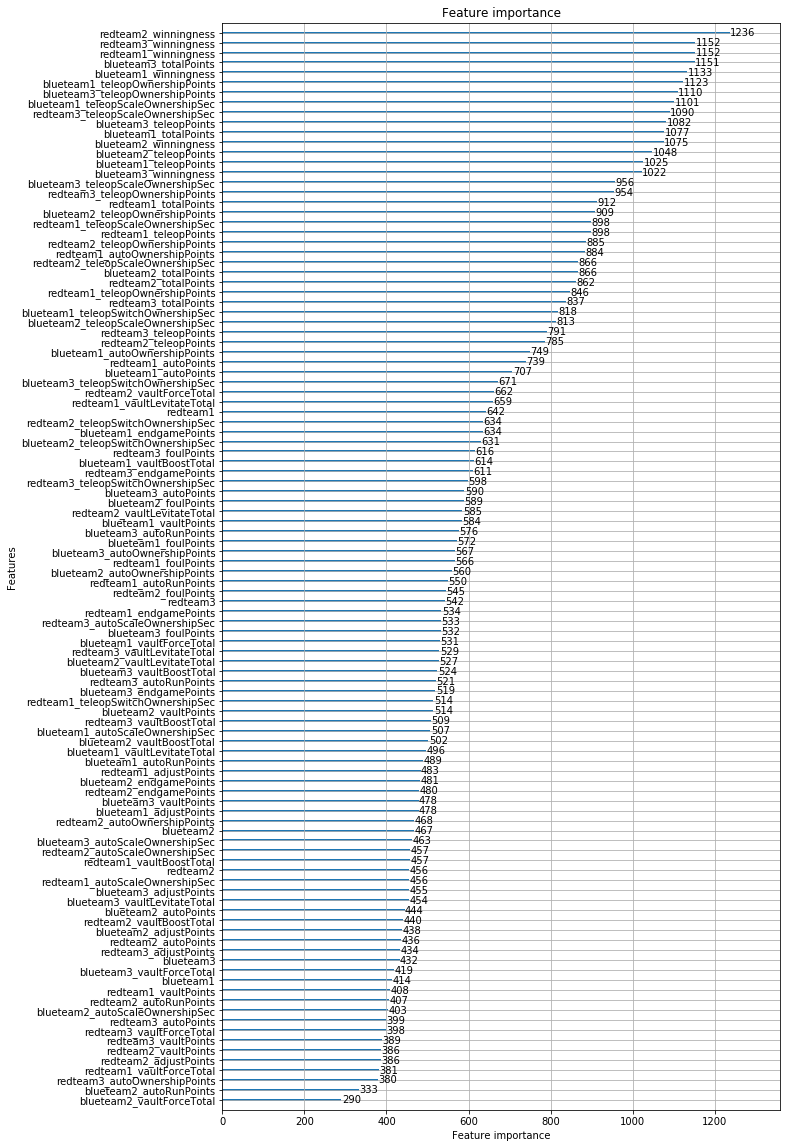

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
lgb.plot_importance(clf, figsize=(10,20))
plt.show()

In [6]:
def generate_match(b1, b2, b3, r1, r2, r3):
    b1_df = pd.DataFrame(team_data[team_data['team'] == b1])
    b1_df = b1_df.drop(['team'], axis = 1)
    b1_df.rename(columns=lambda x: 'blueteam1_'+str(x), inplace=True)
    b1_df['blueteam1'] = b1
    b1_df.reset_index(drop=True, inplace=True)
    
    b2_df = pd.DataFrame(team_data[team_data['team'] == b2])
    b2_df = b2_df.drop(['team'], axis = 1)
    b2_df.rename(columns=lambda x: 'blueteam2_'+x, inplace=True)
    b2_df['blueteam2'] = b2
    b2_df.reset_index(drop=True, inplace=True)
    
    b3_df = pd.DataFrame(team_data[team_data['team'] == b3])
    b3_df = b3_df.drop(['team'], axis = 1)
    b3_df.rename(columns=lambda x: 'blueteam3_'+x, inplace=True)
    b3_df['blueteam3'] = b3
    b3_df.reset_index(drop=True, inplace=True)
    
    r1_df = pd.DataFrame(team_data[team_data['team'] == r1])
    r1_df = r1_df.drop(['team'], axis = 1)
    r1_df.rename(columns=lambda x: 'redteam1_'+x, inplace=True)
    r1_df['redteam1'] = r1
    r1_df.reset_index(drop=True, inplace=True)
    
    r2_df = pd.DataFrame(team_data[team_data['team'] == r2])
    r2_df = r2_df.drop(['team'], axis = 1)
    r2_df.rename(columns=lambda x: 'redteam2_'+x, inplace=True)
    r2_df['redteam2'] = r2
    r2_df.reset_index(drop=True, inplace=True)
    
    r3_df = pd.DataFrame(team_data[team_data['team'] == r3])
    r3_df = r3_df.drop(['team'], axis = 1)
    r3_df.rename(columns=lambda x: 'redteam3_'+x, inplace=True)
    r3_df['redteam3'] = r3
    r3_df.reset_index(drop=True, inplace=True)
    
    df = b1_df.join([b2_df, b3_df, r1_df, r2_df, r3_df])
    
    return df.reindex_axis(sorted(df.columns), axis=1)
    

In [17]:
team_data = pd.read_pickle('data/team_data.pkl')
#team_data.set_index('team', inplace=True)
match = generate_match( 1533,3506,6908, 3737,2642,5160)

result = clf.predict(match)[0]
print(result[0], result[1])
if(result[0] > result[1]):
    print('Blue')
else:
    print('Red')

0.2729578348743719 0.7269503409463243
Red
